In [6]:
import pandas as pd
from model.op import FleetSizeOptimizer
import numpy as np
20+21+11+15

67

In [5]:
w = FleetSizeOptimizer(flight_time=np.array([[0, 20],[20, 0]]).astype(int), 
                       energy_consumption=np.array([[0, 25],[25, 0]]).astype(int), 
                       schedule='demand_variation/schedule/alpha_7_demand_500/11_1.csv')
w.optimize(output_path=f'star_network/LR/separate_od/UVS2', verbose=True, optimality_gap=0.05)

Set parameter Threads to value 2
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 2 threads

Optimize a model with 21630 rows, 348084 columns and 681170 nonzeros
Model fingerprint: 0xfd7b4f9a
Variable types: 0 continuous, 348084 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 2291 rows and 32431 columns
Presolve time: 0.59s
Presolved: 19339 rows, 315653 columns, 637835 nonzeros
Variable types: 0 continuous, 315653 integer (14 binary)
Deterministic concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.57s

Barrier statistics:
 AA' NZ     : 3.297e+05
 Factor NZ  : 7.582e+06 (roughly 200 MB of memory

FileNotFoundError: [Errno 2] No such file or directory: 'output/star_network/LR/separate_od/UVS2_fleetsize.txt'

In [ ]:
w.parse_result('rl_sample/500pax_0206.txt')
w.calculate_aircraft_states()
w.get_summary_statistics(np.array([[0, 10],[10, 0]]).astype(int))

In [9]:
pax_arrival_time = pd.read_csv('input/icrat_wind/demand/pax_arrival_times_500pax_5min_0206.csv')
schedule = pd.read_csv('input/icrat_wind/demand/schedule_500pax_5min_0206.csv')
num_pax = pd.read_csv('input/icrat_wind/demand/num_pax_500pax_5min_0206.csv')

In [56]:
def get_optimized_waiting_time_statistics(pax_arrival_time, schedule, num_pax, return_num=False):
    schedule['schedule'] = np.ceil(schedule['schedule']/5)*5

    schedule_arr = schedule[schedule['od'] == 'LAX_DTLA']['schedule'].to_numpy()
    pax_arrival_arr = pax_arrival_time[pax_arrival_time['origin_vertiport_id'] == 'LAX']['passenger_arrival_time'].to_numpy()
    num_pax_arr = num_pax[num_pax['od'] == 'LAX_DTLA']['num_pax'].to_numpy()

    departure_time = np.zeros(0)
    for i in range(len(schedule_arr)):
        departure_time = np.append(departure_time, np.repeat(schedule_arr[i], num_pax_arr[i]))
    waiting_time = departure_time * 60 - pax_arrival_arr

    schedule_arr = schedule[schedule['od'] == 'DTLA_LAX']['schedule'].to_numpy()
    pax_arrival_arr = pax_arrival_time[pax_arrival_time['origin_vertiport_id'] == 'DTLA']['passenger_arrival_time'].to_numpy()
    num_pax_arr = num_pax[num_pax['od'] == 'DTLA_LAX']['num_pax'].to_numpy()

    departure_time = np.zeros(0)
    for i in range(len(schedule_arr)):
        departure_time = np.append(departure_time, np.repeat(schedule_arr[i], num_pax_arr[i]))
    waiting_time2 = departure_time * 60 - pax_arrival_arr

    waiting_time = np.append(waiting_time, waiting_time2)/60
    if return_num:
        return waiting_time.mean(), waiting_time.std(), waiting_time.max(), waiting_time.min(), len(waiting_time)
    else:
        print(f'Mean waiting time: {waiting_time.mean()}')
        print(f'Standard deviation of waiting time: {waiting_time.std()}')
        print(f'Maximum waiting time: {waiting_time.max()}')
        print(f'Minimum waiting time: {waiting_time.min()}')

In [59]:
print('500pax_5min_0206')
print('----------------')
get_optimized_waiting_time_statistics(pax_arrival_time, schedule, num_pax)

500pax_5min_0206
----------------
Mean waiting time: 5.0287361769352295
Standard deviation of waiting time: 2.395215013069476
Maximum waiting time: 10.0
Minimum waiting time: 0.0


In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)
from matplotlib.ticker import MultipleLocator
import matplotlib
color_platte = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

In [ ]:
file_path = 'save.txt'
file_path2 = 'save2.txt'

dual_obj_values = []
dual_obj_values2 = []
def read_txt_dual(file_path):
    dual_obj_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'dual_obj:' in line:
                match = re.search(r'dual_obj:\s+(\d+\.\d+)', line)
                if match:
                    dual_obj_values.append(float(match.group(1)))
    return np.array(dual_obj_values)

dual_obj_values = read_txt_dual(file_path)
dual_obj_values = dual_obj_values[:650]

dual_obj_values2 = read_txt_dual(file_path2)
dual_obj_values2 = dual_obj_values2[:600]

FileNotFoundError: [Errno 2] No such file or directory: 'save.txt'

In [ ]:
dual_obj_values = np.concatenate((dual_obj_values, dual_obj_values2))

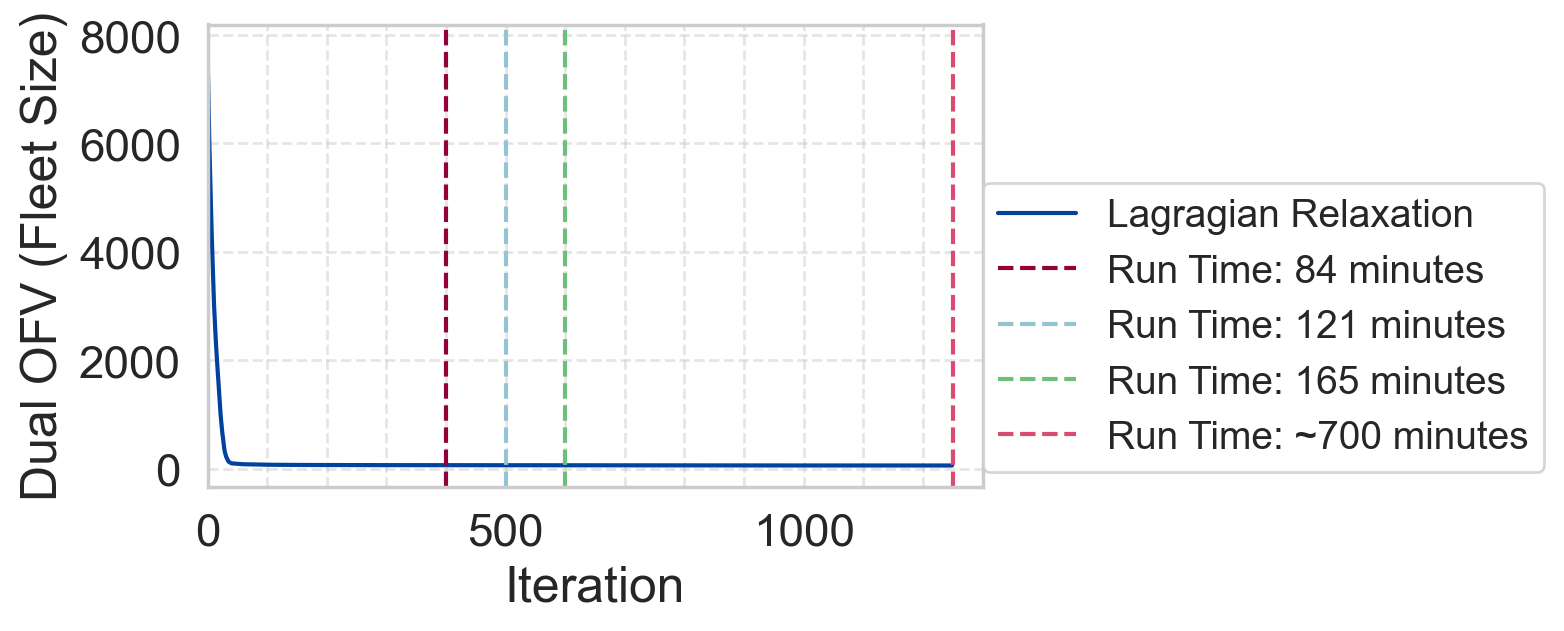

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
ax.plot(dual_obj_values, color=color_platte[1], label='Lagragian Relaxation')
ax.set(xlabel='Iteration', ylabel='Dual OFV (Fleet Size)')
ax.axvline(x=400, color=color_platte[0], linestyle='--', label='Run Time: 84 minutes')
ax.axvline(x=500, color=color_platte[2], linestyle='--', label='Run Time: 121 minutes')
ax.axvline(x=600, color=color_platte[3], linestyle='--', label='Run Time: 165 minutes')
ax.axvline(x=1250, color='#d94c70', linestyle='--', label='Run Time: ~700 minutes')
ax.set(xlim=(0, 1300))
minorLocator = MultipleLocator(100)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(True, alpha=0.5, linestyle='--', which='both')
ax.legend(loc='upper right', bbox_to_anchor=(1.75, 0.7))


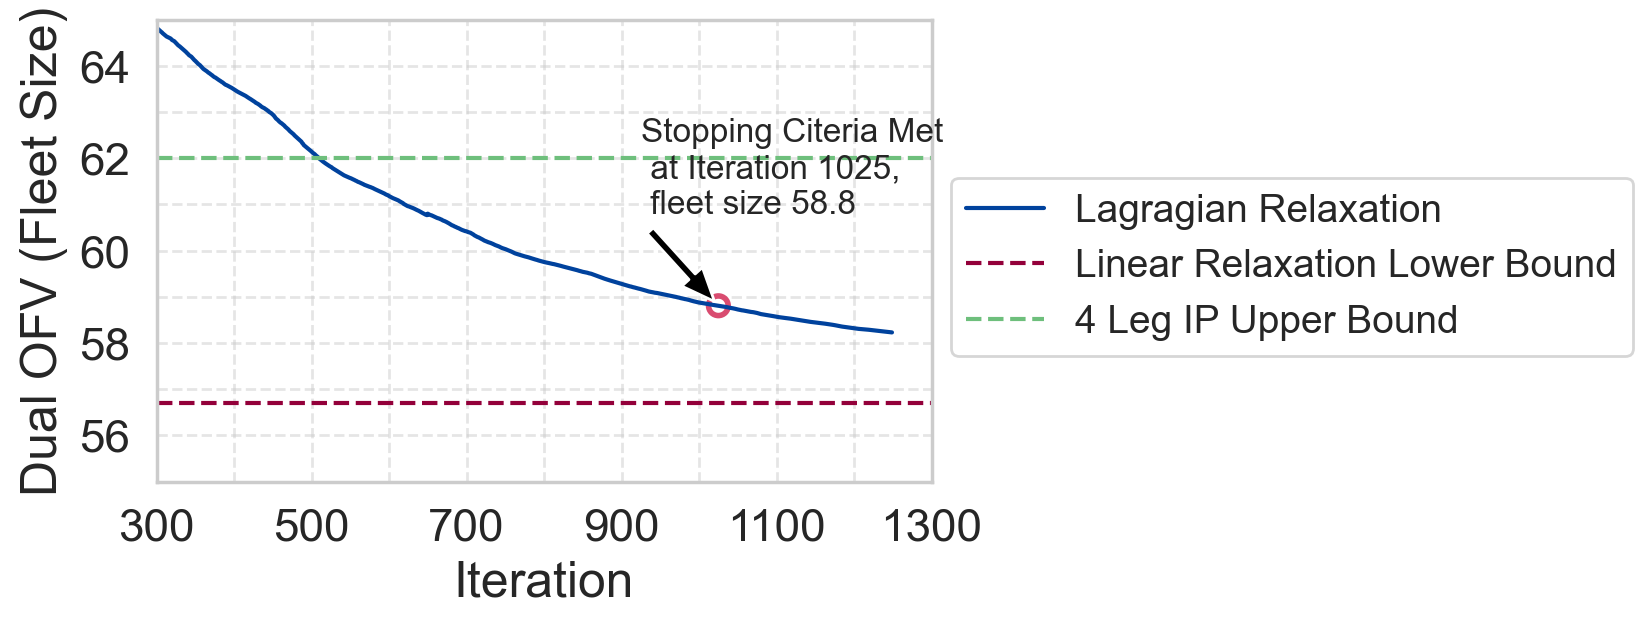

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
ax.plot(dual_obj_values[300:], color=color_platte[1], label='Lagragian Relaxation')
ax.set(xticks=np.arange(0, 1100, 200), xticklabels=np.arange(300, 1400, 200),
       xlabel='Iteration', ylabel='Dual OFV (Fleet Size)', ylim=(55, 65), xlim=(0, 1000))
minorLocator = MultipleLocator(100)
y_minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_minor_locator(y_minorLocator)
ax.grid(True, alpha=0.5, linestyle='--', which='both')
ax.axhline(56.69, color=color_platte[0], linestyle='--', label='Linear Relaxation Lower Bound')
ax.axhline(62, color=color_platte[3], linestyle='--', label='4 Leg IP Upper Bound')

ax.scatter(x=1025-300, y=dual_obj_values[1025], edgecolors='#d94c70', facecolor='none', s=50, linewidths=2)

highlight_x = 1025-300
highlight_y = dual_obj_values[1025]
ax.annotate(f'Stopping Citeria Met \n at Iteration 1025, \n fleet size {round(highlight_y,2)}', xy=(highlight_x, highlight_y), fontsize=12,xytext=(highlight_x-100, highlight_y+2),
            arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=10))
ax.legend(loc='upper right', bbox_to_anchor=(1.93, 0.7))

In [ ]:
np.where(dual_obj_values[:-1]-dual_obj_values[1:] < 0.002)

(array([  40,   42,   44,   48,   50,   51,  649,  943, 1009, 1014, 1024,
        1025, 1027, 1055, 1067, 1091, 1098, 1107, 1108, 1112, 1115, 1122,
        1141, 1142, 1144, 1147, 1149, 1150, 1154, 1155, 1156, 1157, 1158,
        1170, 1185, 1186, 1190, 1202, 1203, 1204, 1206, 1207, 1208, 1210,
        1212, 1213, 1214, 1215, 1216, 1217, 1218, 1220, 1221, 1223, 1224,
        1225, 1226, 1227, 1230, 1234, 1235, 1237, 1238, 1241, 1242, 1243,
        1245, 1248]),)